In [42]:
# Basic Modules
import os
import csv
import xlrd
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Sklearn 
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, make_scorer

# Plot
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.cm as cm
%matplotlib inline

# Functions

In [77]:
# -------------------------------------------------------------------------------------------------------------------
# Dataframe check
# -------------------------------------------------------------------------------------------------------------------
def check_df(var):
    print('Variable check results.\n')
    # Check to see if var is a DataFrame
    if isinstance(var, pd.DataFrame):
        #
        print('Type: ', type(var),'.\n')
        # Missing Data Check
        if var.isnull().sum().sum() == 0:
            print('Passed: Missing data check.\n')
        else:
            print('Failed: Missing data check.\n')
    else:
        print('Not a dataframe.\n')
    # The shape of the dataframe
    print ("Variable Shape:", var.shape, '\n')

    
# -------------------------------------------------------------------------------------------------------------------
# Function: Fetch or Import Data
# -------------------------------------------------------------------------------------------------------------------
def fetch_data():
    # User Data
    path_users = '/Users/edtawhotmail/Documents/GitHub/Data/Ed - GOAT User Persona Analysis/data/processed/goat_user_Q2_2017_US_Cohort_With_gender_race__income_population_10k.csv'
    df_users = pd.read_csv(path_users, sep=',', header=0)
    df_users.drop(['Unnamed: 0'], axis=1, inplace=True)

    # Buyer Data
    path_buyers = '/Users/edtawhotmail/Documents/GitHub/Data/Ed - GOAT User Persona Analysis/data/internal/BuyerdataforPersonaanalysis_2018-11-1_1257.csv'
    df_buyers = pd.read_csv(path_buyers, sep=',', header=0)

    # Merge Data
    df_users_buyers = df_users.merge(df_buyers, left_on='user_id', right_on='user_id', how='inner')

    # Rename columns
    df_users_buyers.rename(columns={'household_median_income':'income',
                                    'total_population':'pop',
                                    'avg_accountageindaysatpurchase':'account_age',
                                    'buyer_returns':'returns',
                                    'early_buyer_returns':'early_returns',
                                    'american_express':'amex',
                                    'store_credit':'credit',
                                    "postal_code_split":"zip_code", 
                                    "final_gender":"gender", 
                                    "final_race":"race"}, inplace=True)
    # Final traning dataframe.
    df_users_buyers = df_users_buyers.loc[df_users_buyers['orders']>2]    
    
    return df_users_buyers    


# -------------------------------------------------------------------------------------------------------------------
# Function: Clean and Transform Data
# -------------------------------------------------------------------------------------------------------------------
def transform_data(df_raw_data):
    # Check Data
    check_df(df_raw_data)  

    # Create tmp dataframe to check for negative values
    # PowerTransfers 'box-cox' method do not like negative numbers.
    df_check_negative_values = df_raw_data.drop([
        'user_id',
        'name',
        'billing_payment_type',
        'zip_code',
        'gender',
        'race',
        'useraccountdate'  
    ], axis=1)

    # Check for negative numbers again after merge.
    print("Found", sum(n < 0 for n in df_check_negative_values.values.flatten()), "rows with negative numbers.")

    # Clean up
    del(df_check_negative_values)

    # Select certain columns.
    df_select_columns = df_raw_data.drop([
        'user_id',
        'name',
        'billing_payment_type',
        'zip_code',
        'gender',
        'race',
        'useraccountdate',
    #    'orders',
    #    'sneaker_revenue',
        'shipping_revenue',
        'stripe',
    #    'android',
    #    'web',
    #    'visa',
    #    'mastercard',
    #    'discover',
    #    'diners_club',
    #    'jcb',
    #    'unionpay'
    ], axis=1)

    # Final traning dataframe.
    # df_select_columns = df_select_columns.loc[df_select_columns['orders']>2]
    
    return df_select_columns


# -------------------------------------------------------------------------------------------------------------------
# Pipeline and GridSearchCV (Without Scoring)
# Silhouette scoring is not available, all available cluster scoring method for GridSearchCV need ground truth class assignment.
# Command for the scoring available for GridSearchCV, sorted(sklearn.metrics.SCORERS.keys())
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# -------------------------------------------------------------------------------------------------------------------
def cluster_gridsearch(X, pca_components=None, k_clusters=None, k_splits=None):
    # Check function parameters
    if pca_components == None:
        pca_components = [2,3,5,10]
    else:
        pca_components = pca_components
    
    if k_clusters == None:
        k_clusters = [2,3,4,5]        
    else:
        k_clusters = k_clusters
        
    if k_splits == None:
        k_splits = 5        
    else:
        k_splits = k_splits
        
    # Pipeline
    estimators = [('p_transform', PowerTransformer()), ('reduce_dim', PCA()), ('k_means', KMeans())]
    pipe = Pipeline(estimators)

    # GridSearchCV
    param_grid = dict(p_transform__method=['yeo-johnson'], p_transform__standardize=[True], 
                      p_transform__copy=[True], 
                      reduce_dim__n_components=pca_components,reduce_dim__random_state = [seed],
                      k_means__n_clusters=k_clusters, k_means__random_state = [seed])
    grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_splits)
    grid_search.fit(X)

    # Print results
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    #return 0


# -------------------------------------------------------------------------------------------------------------------
# A method to find the optimal number of clusters using silhouette analysis.
# We can probably modify the code to loop through a set of PCA components.
# Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# -------------------------------------------------------------------------------------------------------------------
def cluster_silhouette(df_X, pca_components=None, k_clusters=None, k_splits=None):
    # Check function parameters
    if pca_components == None:
        pca_components = [2,3,5,10]
    else:
        pca_components = pca_components
    
    if k_clusters == None:
        k_clusters = [2,3,4,5]        
    else:
        k_clusters = k_clusters
        
    if k_splits == None:
        k_splits = 5        
    else:
        k_splits = k_splits
      
    # There are 2 types of methods, 'yeo-johnson' and 'box-cox')
    pow_transformer = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
    pow_transformer.fit(df_X)
    X_transformed = pow_transformer.transform(df_X)

 #   range_n_components = [2, 4, 6, 8, 10]
 #   range_n_clusters = [2, 3, 4, 5, 6]

    for n_components in pca_components:
        reducer = PCA(n_components=n_components, random_state=seed)
        X = reducer.fit_transform(X_transformed)
        for n_clusters in k_clusters:
            # Create a subplot with 1 row and 2 columns
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18, 7)

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 but in this example all
            # lie within [-0.1, 1]
            ax1.set_xlim([-0.1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer = KMeans(n_clusters=n_clusters, random_state=seed)
            cluster_labels = clusterer.fit_predict(X)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            print("For n_components =", n_components,
                  "For n_clusters =", n_clusters,
                  "The average silhouette_score is :", silhouette_avg)

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k')

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c="white", alpha=1, s=200, edgecolor='k')

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                            s=50, edgecolor='k')

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

            plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                          "with n_clusters = %d" % n_clusters),
                         fontsize=14, fontweight='bold')

    return plt.show()


# -------------------------------------------------------------------------------------------------------------------
# Cross Validate.
# Note, GridSearchCV performs cross validation as part of it process. But, since we reran
# the analysis using the custom silhouette analysis we will run cross validation to be sure.
# -------------------------------------------------------------------------------------------------------------------
def cluster_cross_validate(X, pca_components=None, k_clusters=None, k_splits=None):
    # Check function parameters
    if pca_components == None:
        pca_components = 2
    else:
        pca_components = pca_components
    
    if k_clusters == None:
        k_clusters = 5        
    else:
        k_clusters = k_clusters
        
    if k_splits == None:
        k_splits = 5        
    else:
        k_splits = k_splits
                
    # Pipeline
    estimators = []
    estimators.append(('p_transform',PowerTransformer(method='yeo-johnson', standardize=True, copy=True)))
    estimators.append(('reduce_dim', PCA(n_components=pca_components, random_state=seed)))
    estimators.append(('k_means', KMeans(n_clusters=k_clusters, random_state=seed)))

    model = Pipeline(estimators)
    results_model = model.fit_predict(X)
    kfold = KFold(n_splits=k_splits, random_state=seed)
    results_val = cross_val_score(model, X, cv=kfold)
    print(results_val)
    print(results_val.mean())
    return results_model

    
# -------------------------------------------------------------------------------------------------------------------
# Elbow Analysis
# -------------------------------------------------------------------------------------------------------------------
def kmeans_elbow(X, n_components=None):
    # Find the optimal number of clusters using the elbow method.
    # Reference: Sebastian, "Python Machine Learning", Chapter 11.
    distortions = []
    for i in range(1, n_components):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)
    plt.plot(range(1,n_components), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    # Using the 'elbow method' to determine the optimal number of clusters.
    # We don't see an elbow in our plot vs. the example in the book.     

    
# -------------------------------------------------------------------------------------------------------------------
# Output centroid statistics.
# -------------------------------------------------------------------------------------------------------------------    
def output_centroids(df_X, path):
    #path = '/Users/edtawhotmail/Documents/GitHub/Ed - GOAT User Persona Analysis/centroids.csv'

    for i in df_X['cluster'].unique():
        df_tmp = df_X.loc[df_X['cluster']== i].describe()
        df_tmp['label'] = i

        with open(path, 'a') as f:
            df_tmp.to_csv(f, mode='a', header=f.tell()==0)

    df_tmp = df_X.describe()
    df_tmp['label'] = 'all'

    with open(path, 'a') as f:
            df_tmp.to_csv(f, mode='a', header=f.tell()==0)     

# Main

Variable check results.

Type:  <class 'pandas.core.frame.DataFrame'> .

Passed: Missing data check.

Variable Shape: (1185, 33) 

Found 0 rows with negative numbers.
-317.7050657501731
{'k_means__n_clusters': 5, 'k_means__random_state': 10, 'p_transform__copy': True, 'p_transform__method': 'yeo-johnson', 'p_transform__standardize': True, 'reduce_dim__n_components': 2, 'reduce_dim__random_state': 10}


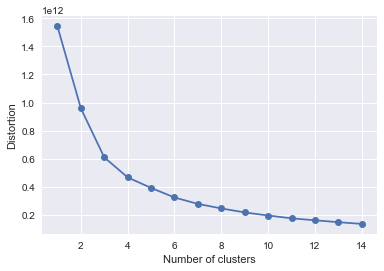

[-382.32345401 -277.0971365  -305.35049654 -319.44546672 -304.30877497]
-317.7050657501731


In [79]:
# Value for random state.
seed = 10

# Fetch and transform data.
df_data = fetch_data()
df_X = transform_data(df_data)

# Hyperparameter tuning.
cluster_gridsearch(df_X.values)

# Takes longer to run the below hyperparameter tuning.
# cluster_gridsearch(df_X.values, pca_components = [2,3,4,5,6,7,8,9,10], k_clusters=[2,3,4,5,6,7,8,9,10], k_splits=5)

# Elbow method to confirm the number of clusters for KMeans.
# the GridSearchCV result of converging on the higher number of clusters makes sense given the results from the elbow method.
kmeans_elbow(df_X, n_components=15)

# Cross Validate to confirm GridSearchCV results.
cluster_labels = cluster_cross_validate(df_X.values, pca_components = 2, k_clusters=5, k_splits=5)

# Apply cluster labels to original data.
df_data['cluster'] = cluster_labels

# Export results to CSV files.
path = '/Users/edtawhotmail/Documents/GitHub/Ed - GOAT User Persona Analysis/'
filename_centroids = 'centroids.csv'
filename_data = 'data_with_labels.csv'

output_centroids(df_data, path+filename_centroids)
df_data.to_csv(path+filename_data)

For n_components = 2 For n_clusters = 2 The average silhouette_score is : 0.4779626827386245
For n_components = 2 For n_clusters = 3 The average silhouette_score is : 0.34999759192068475
For n_components = 2 For n_clusters = 4 The average silhouette_score is : 0.36822334763478776
For n_components = 2 For n_clusters = 5 The average silhouette_score is : 0.37271296833103684
For n_components = 3 For n_clusters = 2 The average silhouette_score is : 0.4024051426455929
For n_components = 3 For n_clusters = 3 The average silhouette_score is : 0.3873713820330194
For n_components = 3 For n_clusters = 4 The average silhouette_score is : 0.3001304130091414
For n_components = 3 For n_clusters = 5 The average silhouette_score is : 0.28369748802032346
For n_components = 5 For n_clusters = 2 The average silhouette_score is : 0.3101900842783337
For n_components = 5 For n_clusters = 3 The average silhouette_score is : 0.28347513635226756
For n_components = 5 For n_clusters = 4 The average silhouette_sc

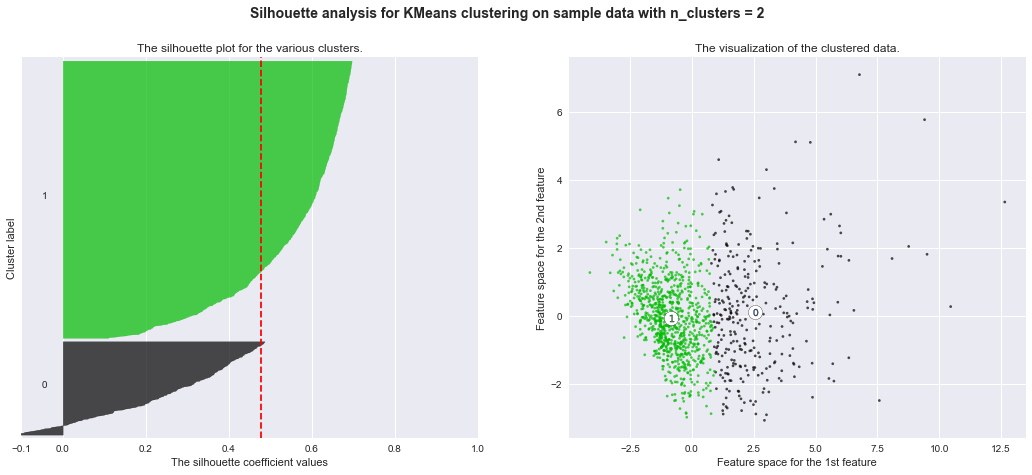

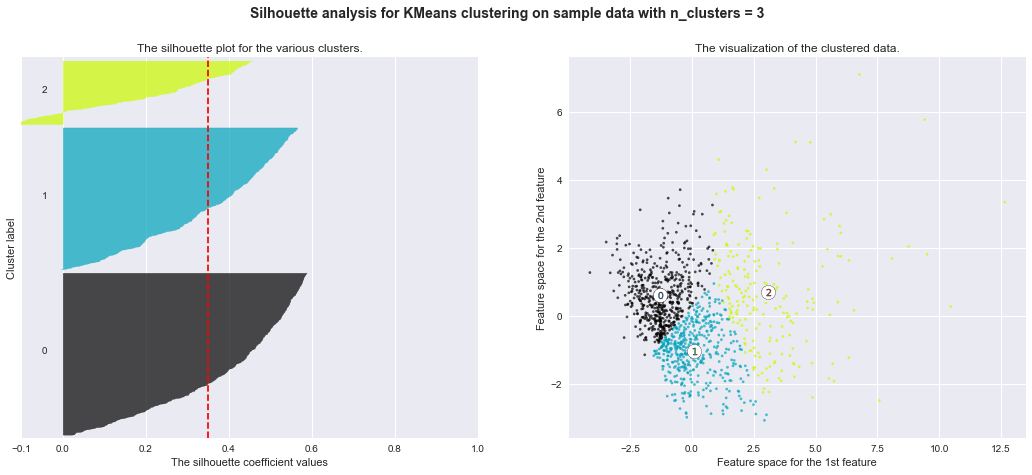

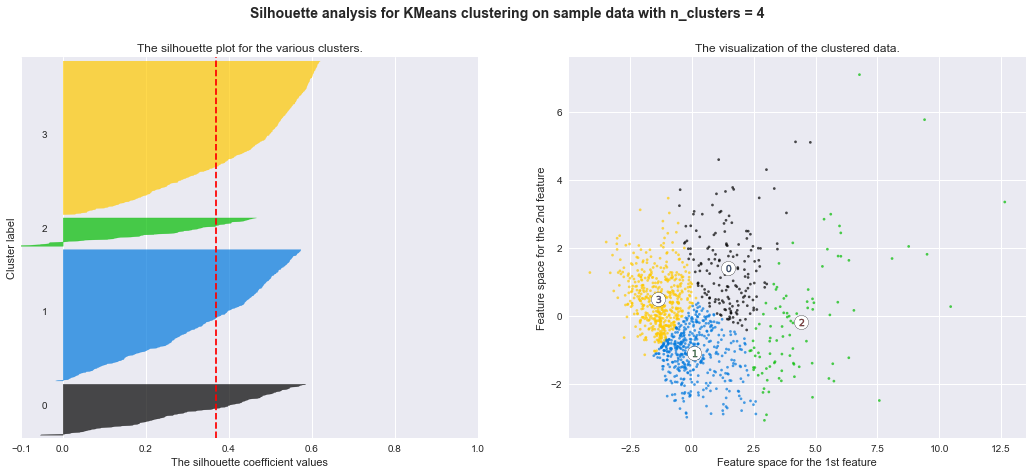

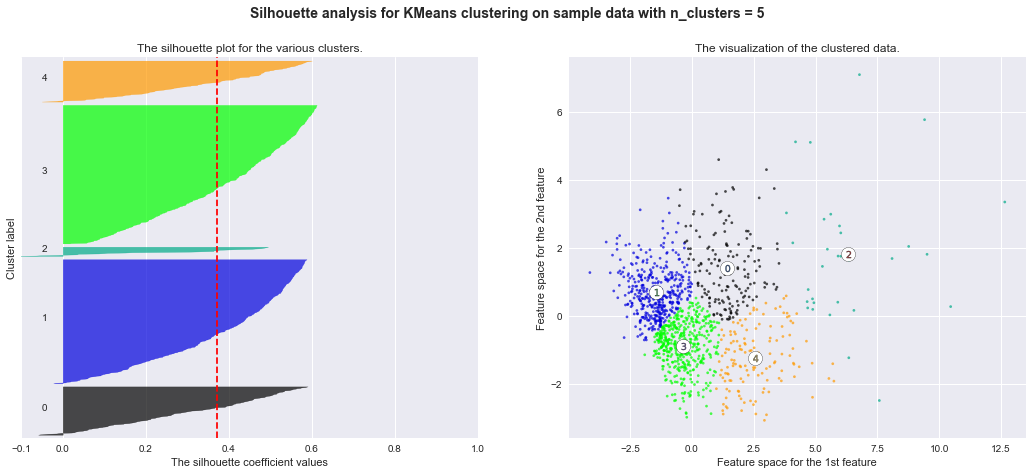

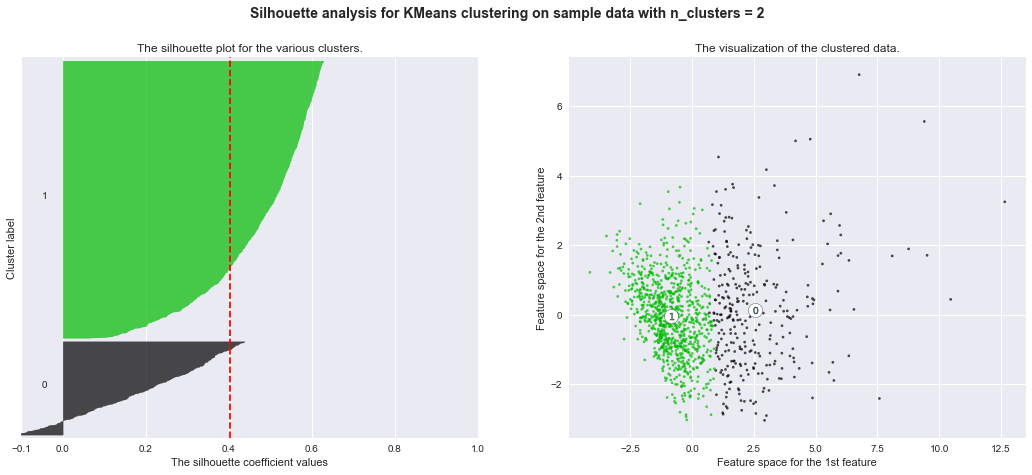

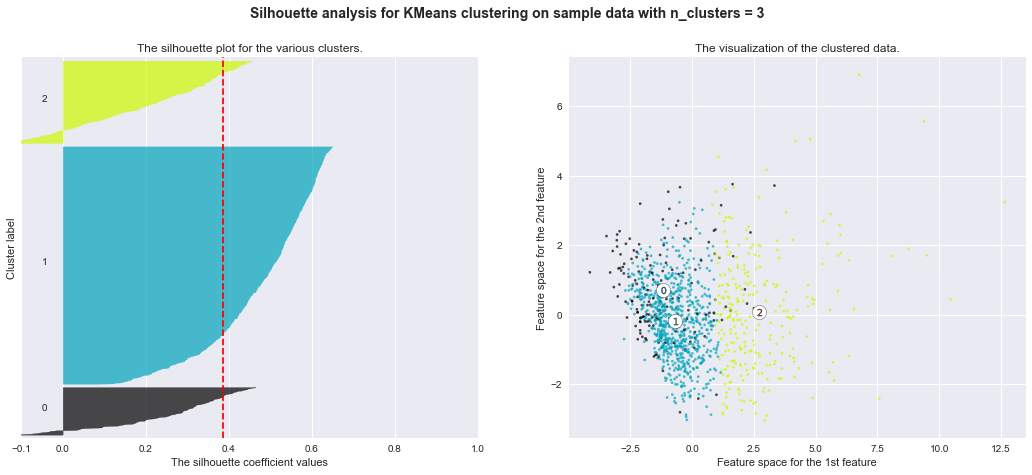

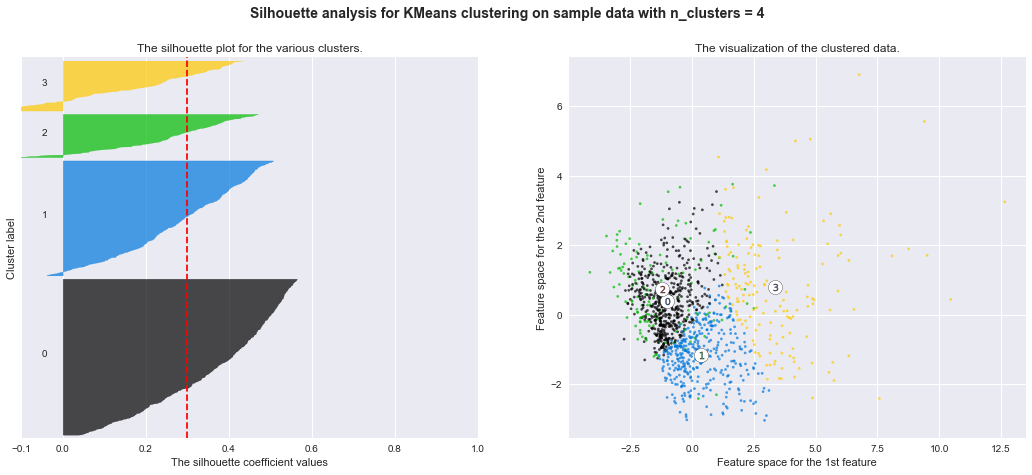

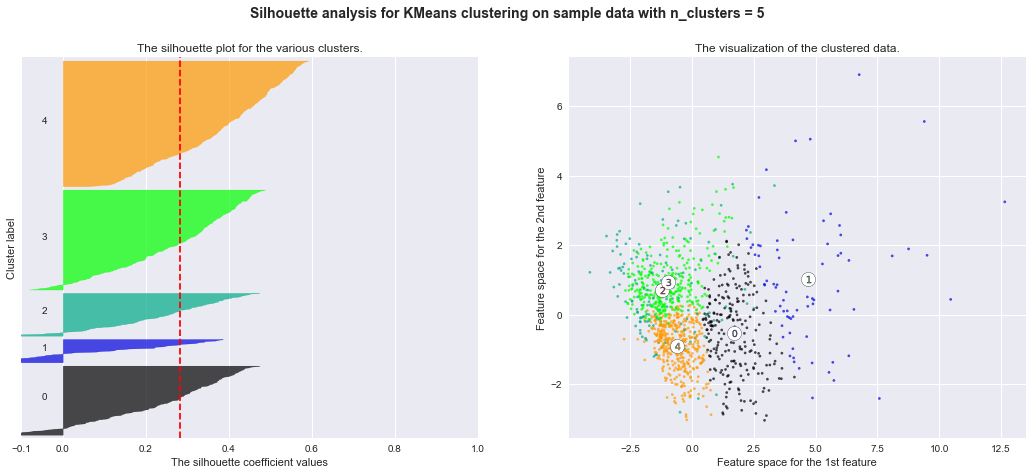

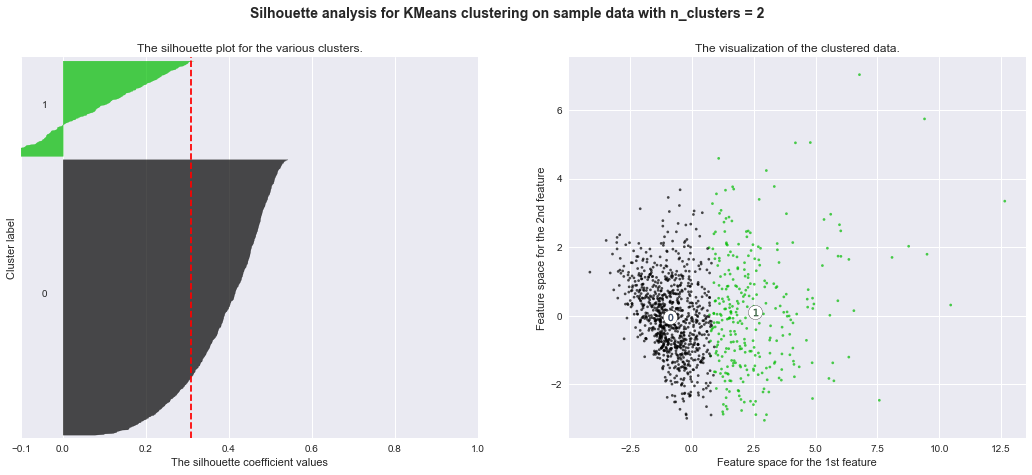

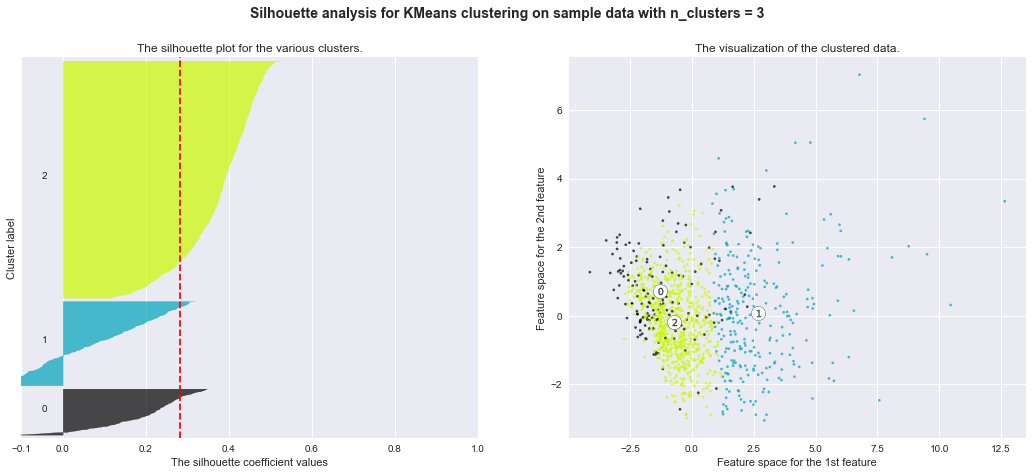

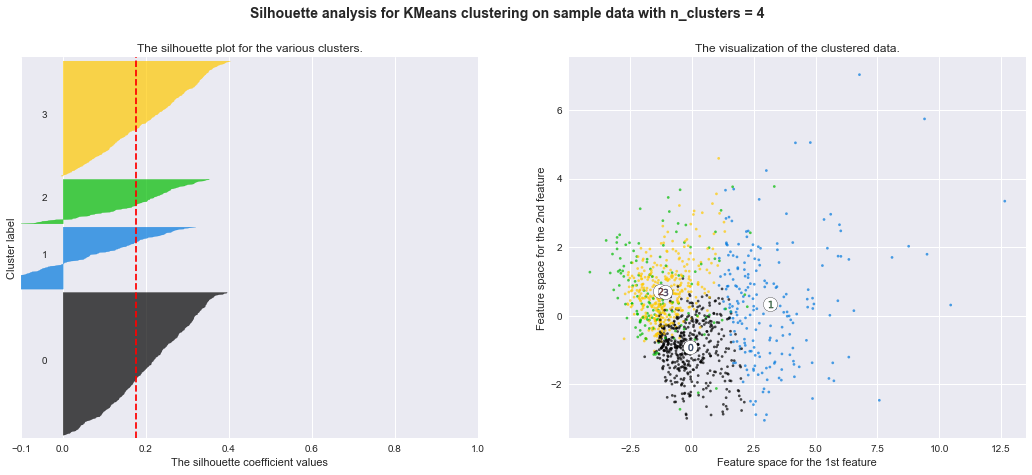

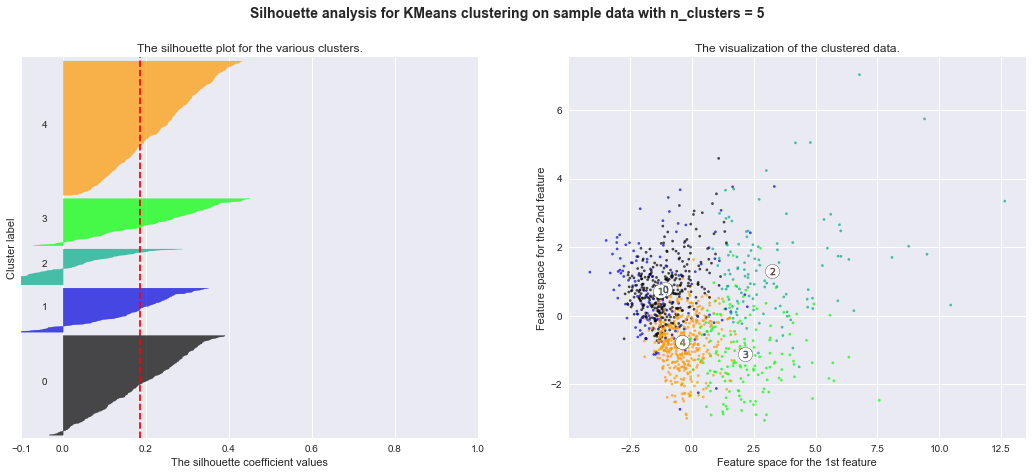

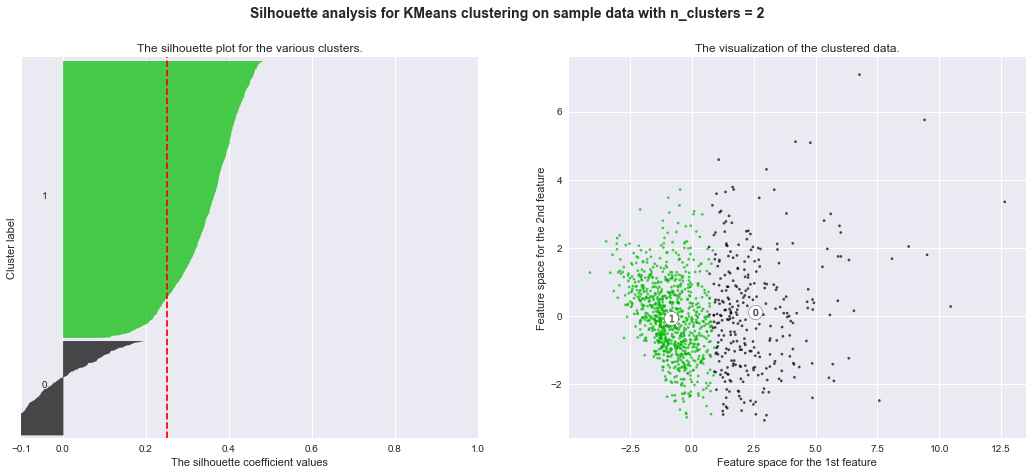

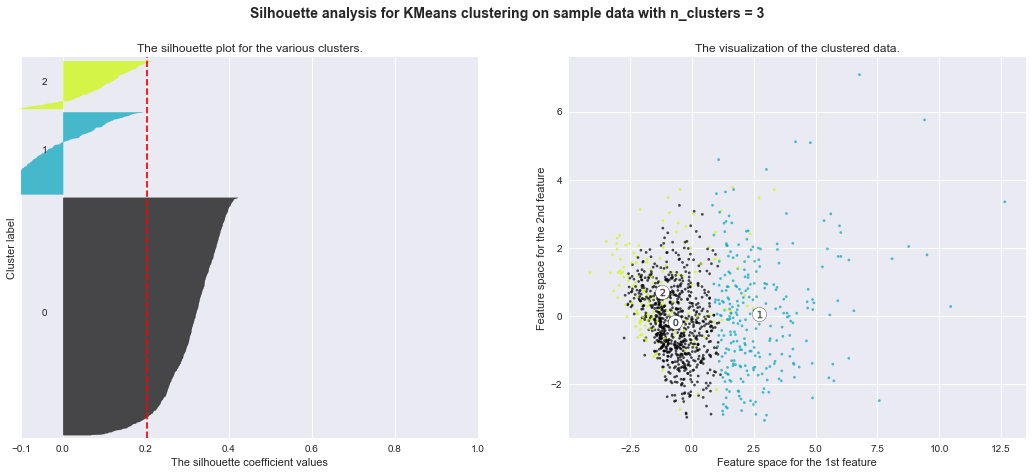

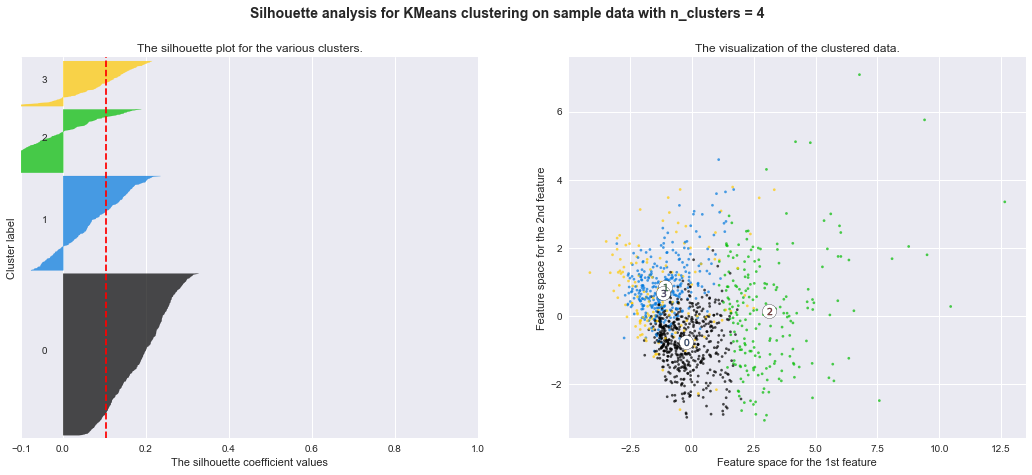

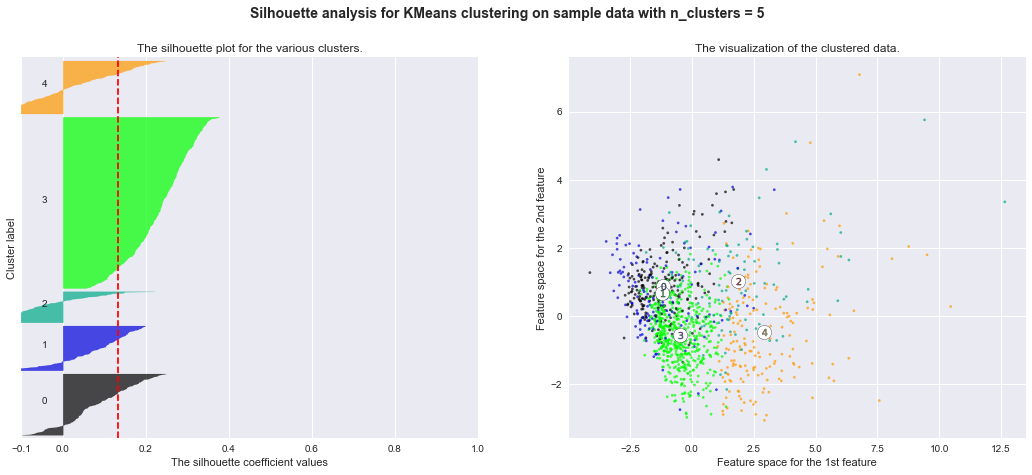

In [6]:
# Optional: Silhouette Analysis
# Visual inspection, confirm the results form GridSearchCV.
cluster_silhouette(df_X.values)